In [132]:
import matplotlib.pyplot as plt
%matplotlib widget
import numpy as np

<figure id="figure-3">
<div style="background-color: white">

![](figures/dct.svg)</div>
    
<figcaption style="text-align: center">Figure 3: A DCT can be treated as an N channel filter bank where the coefficients of the
filters are the basis functions.</figcaption></figure>

# 7 The Discrete Cosine Transform (DCT)


The DCT is a method of performing energy compaction that is rather different
from the pyramid method.  It operates on non-overlapping blocks of pixels
(typically $8 \times 8$ pixels in size) by a reversible linear transform
process, such that each block of pixels is replaced by a block of the same
number of transform coefficients.  If all the transform coefficients for a
given block are transmitted unaltered to the decoder, then the original block
of pixels can be exactly recovered by the inverse transform process.

In practise the transform coefficients are quantised before transmission, and
if energy compaction has occurred, then fewer bits will be needed to send the
coefficients than the original pixels.  A key advantage of transform-based
methods is that there is no expansion of the number of samples (the
transformed block is the same size as the original block of pixels), whereas
the previous pyramid method expands the data by
$1 + \frac{1}{4} + \frac{1}{16} + \ldots \approx 1.33$ times, which is not very desirable for data
compression.

## 7.1 Definition of the DCT


The one-dimensional form of the DCT is closely related to the Discrete Fourier
Transform (DFT).  The 1-D $N$-point DCT is defined as follows:


$$
y(k) = \sum_{n=0}^{N-1} C_{kn}\ x(n) \quad \text{for} \quad 0 \le k \le N-1 \\
  \text{where }\quad C_{0n} = \sqrt{\frac{1}{N}}  \\
    \text{and } \quad C_{kn} = \sqrt{\frac{2}{N}}\ \cos
\frac{k(n+\frac{1}{2})\pi}{N} \quad \text{for} \quad 1 \le k \le N-1
$$

The equivalent inverse DCT is:
$$
x(n) = \sum_{k=0}^{N-1} C_{kn}\ y(k) \quad \text{for} \quad 0 \le n \le N-1 \\
 \text{where $C_{kn}$ is defined as above.}\\
$$

(This is actually the Type-II DCT, and the inverse is the Type-III DCT - other types have slightly different relative phases})

We see that the forward transform is equivalent to multiplication of the
$N$-point column vector $[x(0) \ldots x(N-1)]'$ by an $N \times N$ matrix,
containing $C_{kn}$ at each location $(k,n)$, to produce the $N$-point column
vector $[y(0) \ldots y(N-1)]'$.  Similarly the inverse transform is equivalent
to multiplication of the $y$ vector by the transpose of the $C$ matrix to give
the $x$ vector.  In python3 + numpy notation these become:

`y = C @ x` and `x = C.T @ y`

Note that C is an orthonormal matrix since its inverse is just its
transpose (its rows are othogonal to each other and have unit energy).

The two-dimensional version of the DCT (as used for image compression) is a
simple extension of the above 1-D DCT.  For an $N \times N$ block of pixels,
the $N$-point 1-D DCT is first applied to each column of the block to give $N$
columns of coefficients.  Then the same 1-D DCT is applied to the rows of
these coefficients to give the 2-D transform coefficients.

In python3 + numpy notation, if the input block of pixels is matrix X, the output
block of 2-D transformed coefficients Y is given by:

`Y = (C @ (C @ X).T).T` or more simply `Y = C @ X @ C.T`

where C is the 1-D transform matrix as above.  Note that in the 2-D
transform, it does not matter whether the rows or the columns are transformed
first (because the transform is linear and separable).


## 7.2 Applying the DCT to images

Conceptually the 2-D DCT is applied to all non-overlapping $N \times N$ blocks
of pixels in an image (we assume that the image dimensions are exact multiples
of $N$).  However it is simplest and most efficient to perform 1-D
$N$-point DCTs on all the columns of the image first, and then repeat the
operation on the transpose of the result to transform the rows.

**First generate an 8-point 1-D Type-II DCT matrix C8**

In [133]:
from cued_sf2_lab.dct import dct_ii

C8 = dct_ii(8)

Take a look at the function `dct_ii` and list `C8` to check
that it agrees with the definitions for $C_{kn}$ given above:

In [134]:
import inspect
import IPython.display
IPython.display.Code(inspect.getsource(dct_ii), language="python")

def dct_ii(N: int) -> np.ndarray:
    """
    Generate the 1D DCT transform matrix of size N.

    Parameters:
    N (int): Size of DCT matrix required

    Returns:
    C (2D np array): 1D DCT transform matrix

    Uses an orthogonal Type-II DCT.
    Y = C * X tranforms N-vector X into Y.
    """
    C = np.ones((N, N)) / np.sqrt(N)
    theta = (np.arange(N) + 0.5) * (np.pi/N)
    g = np.sqrt(2/N)
    for i in range(1, N):
        C[i, :] = g * np.cos(theta*i)

    return C

**Plot the rows of `C8` using `plot(C8.T)`.**

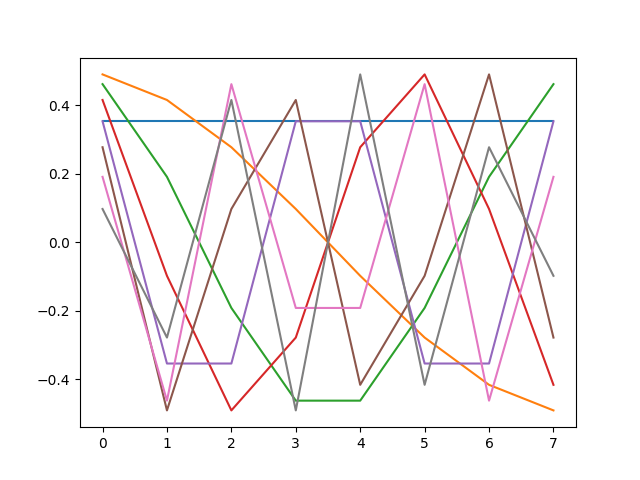

In [135]:
fig, ax = plt.subplots()
ax.plot(C8.T);


When we calculate the 1-D transform of an 8-point block of data, each
transform coefficient represents the component of the data that is
correlated with the corresponding row of `C8`.  Hence the
first coefficient represents the dc component, the second one
represents the approximate average slope, and so on. The later
coefficients represent progressively higher frequency components
in the data.

The function `colxfm(X, C8)` will perform a 1-D transform on
the columns of image `X` using `C8`. We can
therefore perform a 2-D transform on `X` by using `colxfm` twice, once with transpose operators, as follows:

In [136]:
from cued_sf2_lab.familiarisation import load_mat_img
from cued_sf2_lab.dct import colxfm

X_pre_zero_mean, cmaps_dict = load_mat_img(img='lighthouse.mat', img_info='X', cmap_info={'map', 'map2'})
X = X_pre_zero_mean - 128.0

Y = colxfm(colxfm(X, C8).T, C8).T

In `Y`, each $8 \times 8$ block of pixels has been replaced by an
equivalent block of transform coefficients.  The coefficient in the top left
corner of each block represents the dc value of the block of pixels;
coefficients along the top row represent increasing horizontal frequency
components, and along the left column represent increasing vertical frequency
components.  Other coefficients represent various combinations of horizontal
and vertical frequencies, in proportion to their horizontal and vertical
distances from the top left corner.

If we try to display `Y` directly as an image, it is rather
confusing because the different frequency components of each block
are all present adjacent to each other.  

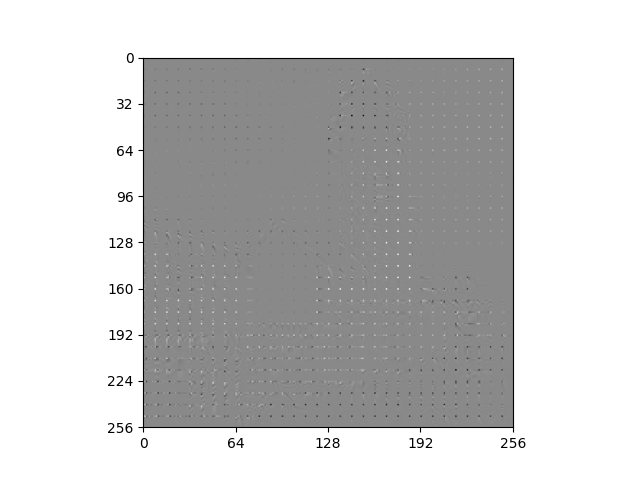

In [137]:
from cued_sf2_lab.familiarisation import plot_image

fig, ax = plt.subplots()
plot_image(Y, ax=ax);

A much more meaningful
image is created if we group all the coefficients of a given type
together into a small sub-image, and display the result as an $8
\times 8$ block of sub-images, one for each coefficient type.  The
function `regroup(Y, N)` achieves this regrouping, where $N$ is
the size of the original transform blocks. You need to ensure that X has zero mean (by subtracting 128) before you start transforming it, otherwise the dc coefficient will be purely positive, whereas the
others are symmetrically distributed about zero. Also, an $N
\times N$ 2-D DCT introduces a gain factor of $N$ in order to
preserve constant total energy between the pixel and transform
domains: we need to divide by $N$ *when displaying* to get back to the expected range.

Hence we can display `Y` meaningfully using:

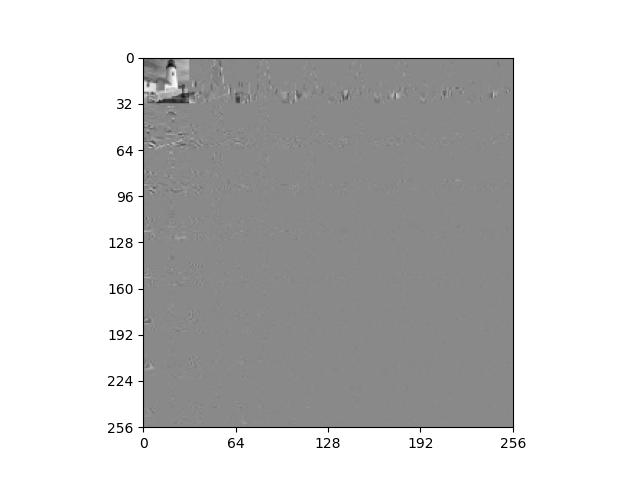

In [138]:
from cued_sf2_lab.dct import regroup

N = 8
fig, ax = plt.subplots()
plot_image(regroup(Y, N)/N, ax=ax);

In this image, you should see a small replica of the original in the top left
corner (the dc coefficients), and other sub-images showing various edges from
the original, representing progressively higher frequencies as you move
towards the lower right corner.

<div class="alert alert-block alert-danger">

What do you observe about the energies of the sub-images as frequencies
increase?</div>

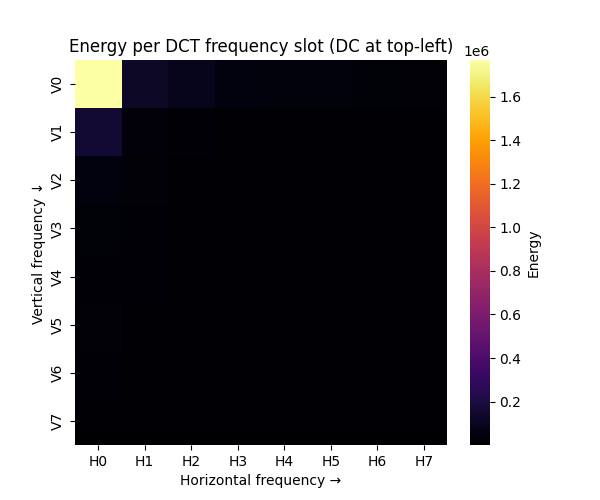


Energy of matrix along diagonal:
1768561.669677734
29150.795897808894
5508.216058428641
2329.776425925917
994.5876464843735
855.7999481931167
553.9863341494854
482.67020854081653


In [139]:
# Your code here
# regroup the coefficients by frequency type and undo the 2-D gain
N = 8
Yg = regroup(Y, N) / N                      # shape is 256×256 again

# ------------------------------------------------------------
# 2. energy of each frequency slot
# ------------------------------------------------------------
energy = np.zeros((N, N))
blk = 32          # because 256 / 8 = 32 blocks per row/col
for v in range(N):          # vertical frequency index
    for h in range(N):      # horizontal frequency index
        tile = Yg[v*blk:(v+1)*blk, h*blk:(h+1)*blk]
        energy[v, h] = np.sum(tile**2)

# ------------------------------------------------------------
# 3. display or print the energy map
# ------------------------------------------------------------
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(energy,
                  index=[f"V{v}" for v in range(N)],
                  columns=[f"H{h}" for h in range(N)])

plt.figure(figsize=(6,5))
sns.heatmap(df, annot=False, cmap="inferno", cbar_kws={"label":"Energy"})
plt.title("Energy per DCT frequency slot (DC at top-left)")
plt.xlabel("Horizontal frequency →")
plt.ylabel("Vertical frequency ↓")
plt.show()

# (optional) print the numeric values
print("\nEnergy of matrix along diagonal:")
for i in range (N):
    print(energy[i, i]) 


Now check that you can recover the original image from Y
by carrying out the inverse transform using:

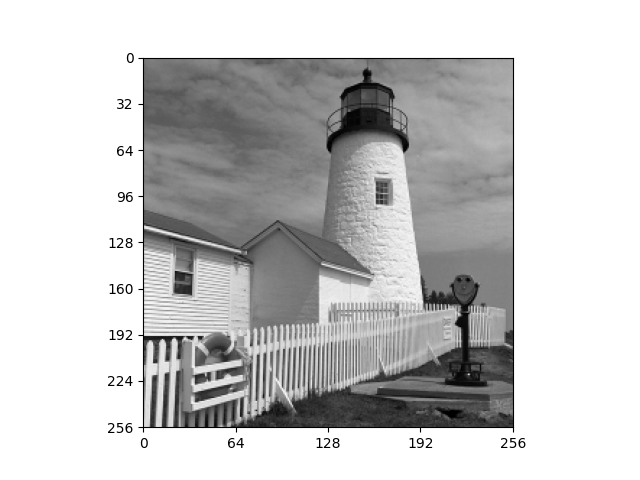

In [140]:
Z = colxfm(colxfm(Y.T, C8.T).T, C8.T)

fig, ax = plt.subplots()
plot_image(Z, ax=ax);

**Measure the maximum absolute error between X and Z
to confirm this.**

In [141]:
# Your code here
max_err = np.abs(Z - X).max()
print(f"maximum absolute error between X and Z is {max_err:.5e}")

maximum absolute error between X and Z is 6.11067e-13


The DCT analyses each $8 \times 8$ block of image pixels into a linear
combination of sixty-four $8 \times 8$ basis functions.  The following will generate
an image comprising these basis functions (the `np.nan`s separate the sub-images as matplotlib draws them as transparent, and the `reshape` function converts from a matrix to a row vector):

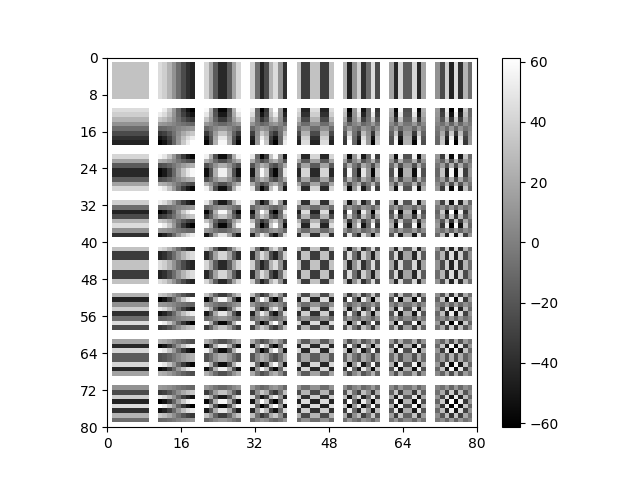

In [142]:
import numpy as np
# Stack some NaNs
bases = np.concatenate([np.full((8, 1), np.nan), C8, np.full((8, 1), np.nan)], axis=1)
# Reshape
bases_flat = np.reshape(bases, (-1, 1))

fig, ax = plt.subplots()
im = plot_image(255*bases_flat@bases_flat.T, ax=ax)
fig.colorbar(im);

<div class="alert alert-block alert-danger">

Explain how this image relates to the DCT coefficients.</div>

## 7.3 Quantisation and Coding Efficiency

We are now going to look at the effects of quantising the DCT coefficients
fairly coarsely and determine the entropies of the coefficient sub-images.
At this stage we shall quantise all sub-images with the same step-size,
since they all are the same size and have unit energy gain from the
quantiser to the output image (due to the orthonormal transform matrices).

First quantise the transformed image Y using a step size
of 17 to give Yq.  Then regroup Yq to form
sub-images of each coefficient type as before, to give Yr. These sub-images have different probability distributions and we can take advantage of this later in coding them efficiently. Hence we get a better estimate of the number of bits required to code Yq by looking at the entropies of each of the re-grouped sub-images separately.

**Write a function `dctbpp(Yr, N)` to calculate the total number of bits from a re-grouped image Yr, by using `bpp(Ys)` on each sub-image Ys of Yr, then multiplying each result by the number of pixels in the sub-image, and summing to give the total number of bits.**

In [143]:
from cued_sf2_lab.laplacian_pyramid import bpp, quantise
import numpy as np
N=8
Yq = quantise(Y, step=17)
Yr = regroup(Yq, N) / N  

def dctbpp(Yr: np.ndarray, N: int) -> int:
    """
    Return the total number of bits required to code the regrouped DCT image Yr.

    Parameters
    ----------
    Yr : 2-D ndarray
        Regrouped DCT coefficients (size 256×256 for an 8×8 block image).
    N  : int
        DCT block size (8 for an 8×8 transform).

    Returns
    -------
    total_bits : int
        Sum over all N×N coefficient sub-images of  bits_per_pixel * pixels_in_subimage.
    """
    blk = Yr.shape[0] // N          # tile size, 256/8 = 32
    total_bits = 0

    for v in range(N):              # vertical frequency index
        for h in range(N):          # horizontal frequency index
            Ys = Yr[v*blk:(v+1)*blk, h*blk:(h+1)*blk]   # 32×32 tile
            total_bits += bpp(Ys) * Ys.size             # entropy × pixels

    return total_bits


<div class="alert alert-block alert-danger">

Visualise Yr and comment on the distributions in each of the sub-images. Use the function `dctbpp(Yr, N)` that you have written to calculate the total number of bits, and compare it with just using `bpp(Yr)`, explaining your results.

</div>

In [144]:
#Because the different tiles have such different variances, computing the bit-rate per tile (your dctbpp) gives a lower—and more realistic—total 
# than treating Yr as one big image and calling bpp(Y_r) once. Coding each coefficient class with its own probability model exploits 
# this strong energy disparity and yields better compression.

Bits (sum of per-tile entropies): 97,467
Bits (only quantised)   : 109,626


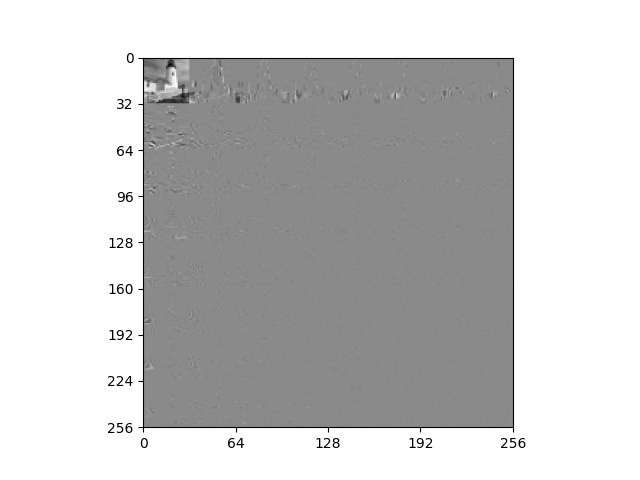

In [145]:
# Your code here
fig, ax = plt.subplots()
plot_image(Yr, ax=ax);
bits_sub = dctbpp(Yr, N=8)
bits_flat = bpp(Yr) * Yr.size
print(f"Bits (sum of per-tile entropies): {bits_sub:,.0f}")
print(f"Bits (only quantised)   : {bits_flat:,.0f}")

<div class="alert alert-block alert-danger">

Now reconstruct the output image `Z` from `Yq` and measure the rms
error (standard deviation) between `X` and `Z`.  Compare this with the
error produced by quantising `X` with a step-size of 17 to give `Xq`.

</div>

In [146]:
# Your code here
#reconstruct Z from Yq
Z = colxfm(colxfm(Yq.T, C8.T).T, C8.T)
rms_err_Z = np.std(X- Z)
Xq = quantise(X, step=17)
rms_err_Xq = np.std(X- Xq)
print(f'rms error between X and Z is {rms_err_Z:.5}')
print(f'rms error between X and Xq is {rms_err_Xq:.5}')


rms error between X and Z is 3.7568
rms error between X and Xq is 4.8612


***As with the Laplacian Pyramid, we really need to contrast compression ratios and visual results on compressed images with the same rms error. Re-use your step optimisation code to calculate the (non-integer) step size required in this case for the same rms error as quantising X with a step-size of 17.***

In [147]:
# Your code here
target_err = 4.8612
def rms_DCT_8 (step: float) -> float:
    Yq = quantise(Y, step)
    Z = colxfm(colxfm(Yq.T, C8.T).T, C8.T)
    #return rms error
    return np.std(X- Z)

def find_step_DCT_8(target_err, lo=1.0, hi=30.0, tol=0.001, max_iter= 5000):
    """Binary-search Δ so that rms_DCT(step) ≈ target_err."""    
    for _ in range(max_iter):          # failsafe upper bound
        mid = 0.5 * (lo + hi)
        e   = rms_DCT_8(mid)

        # stop if we're close enough
        if abs(e - target_err) <= tol:
            return mid, e

        # otherwise shrink the half-interval that gives too much error
        if e > target_err:
            hi = mid          # error too big, we need a smaller step
        if e < target_err:
            lo = mid          # error too small ⇒ we need a larger step

    # If we drop out because of max_iter, return the best we have
    return mid, e   #mid is the matched step size, e is the error

<div class="alert alert-block alert-danger">

Calculate the compression ratio for this scheme compared to direct quantisation. Use `dctbpp` to calculate the number of bits needed. Contrast the visual appearance of the DCT-compressed image, the directly quantised image, and the original image.

</div>

In [148]:
# Your code here
opt_step, opt_error = find_step_DCT_8(4.8612)
print(f"\nmatched step ≈ {opt_step:.3f}  →  RMS = {opt_error:.3f}")


matched step ≈ 23.692  →  RMS = 4.861


In [149]:
# compression ratio when RMS are matched
Yq = quantise(Y, step=opt_step)
print(opt_step)
Yr = regroup(Yq, N) / N  
bits_sub = dctbpp(Yr, N=8)
bits_direct_quantisation = bpp(quantise(X, step=17) )* X.size
compression_ratio = bits_direct_quantisation / bits_sub
print(f"Bits (sum of per-tile entropies): {bits_sub:,.0f}")
print(f"Bits (direcct quantisation)   : {bits_direct_quantisation:,.0f}")
print(f"Comprssion ratio   : {compression_ratio}")




23.691650390625
Bits (sum of per-tile entropies): 77,548
Bits (direcct quantisation)   : 228,119
Comprssion ratio   : 2.941659433573453


Text(0.5, 1.0, 'Original X')

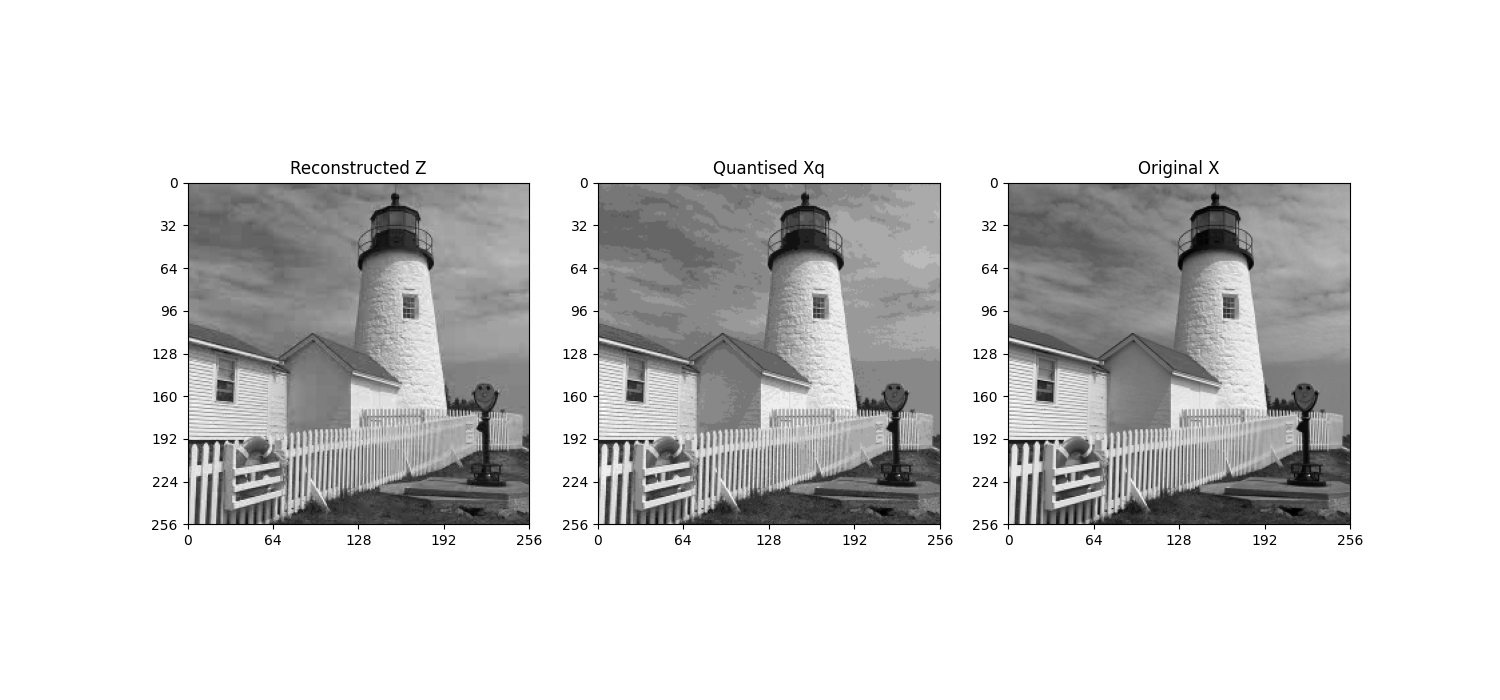

In [150]:
Z = colxfm(colxfm(Yq.T, C8.T).T, C8.T)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 7))
plot_image(Z, ax=ax1); ax1.set_title("Reconstructed Z")
plot_image(Xq, ax=ax2); ax2.set_title("Quantised Xq")
plot_image(X, ax=ax3); ax3.set_title("Original X")



## 7.4 Alternative transform sizes

So far, we have concentrated on $8 \times 8$ DCTs using C8
as the 1-D transform matrix.  **Now generate 4-point and 16-point
transform matrices, C4 and C16 using `dct_ii`.**


In [151]:
# Your code here
C4 = dct_ii(4)
C16 = dct_ii(16)

<div class="alert alert-block alert-danger">

Repeat the main measurements from the previous section, so as to obtain
estimates of the number of bits and compression ratios for $4 \times 4$ and $16 \times 16$ DCTs when the
rms errors are equivalent to those in your previous tests.  Also assess the
relative subjective quality of the reconstructed images.</div>

In [152]:
# Your code here
Y = colxfm(colxfm(X, C4).T, C4).T
Yq = quantise(Y, step=17)
#reconstruct Z from Yq
Z = colxfm(colxfm(Yq.T, C4.T).T, C4.T)
rms_err_Z = np.std(X- Z)
Xq_reference = quantise(X, step=17)
rms_err_Xq = np.std(X- Xq_reference)
print(f'rms error between X and Z is {rms_err_Z:.5}')
print(f'rms error between X and Xq is {rms_err_Xq:.5}')

rms error between X and Z is 3.7368
rms error between X and Xq is 4.8612



matched step ≈ 23.897  →  RMS = 4.861
Bits (sum of per-tile entropies): 86,227
Bits (direcct quantisation)   : 228,119
Comprssion ratio   : 2.645567452301859


Text(0.5, 1.0, 'Original X')

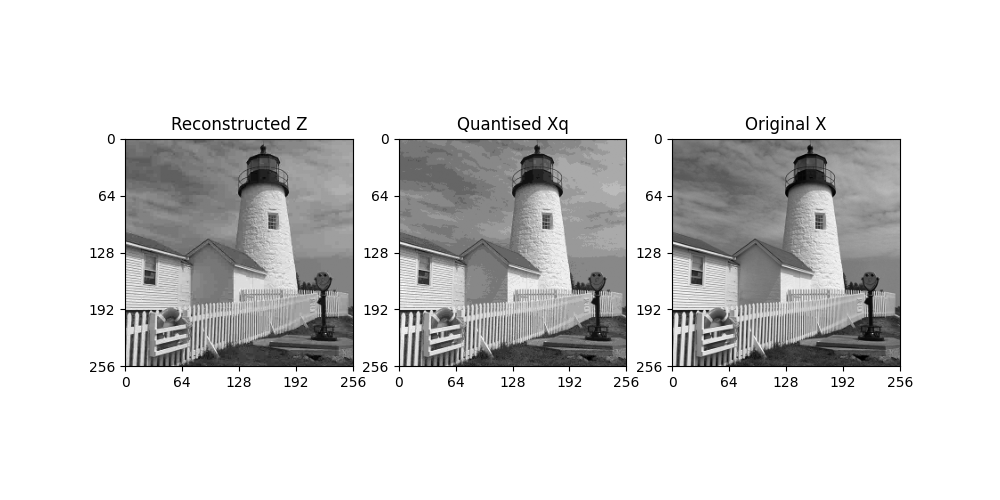

In [153]:
# Your code here
target_err = 4.8612
def rms_DCT_4 (step: float) -> float:
    Yq = quantise(Y, step)
    Z = colxfm(colxfm(Yq.T, C4.T).T, C4.T)
    #return rms error
    return np.std(X- Z)

def find_step_DCT_4(target_err, lo=1, hi=50, tol=0.001, max_iter= 5000):
    """Binary-search Δ so that rms_DCT(step) ≈ target_err."""    
    for _ in range(max_iter):          # failsafe upper bound
        mid = 0.5 * (lo + hi)
        e   = rms_DCT_4(mid)

        # stop if we're close enough
        if abs(e - target_err) <= tol:
            return mid, e

        # otherwise shrink the half-interval that gives too much error
        if e > target_err:
            hi = mid          # error too big, we need a smaller step
        if e < target_err:
            lo = mid          # error too small ⇒ we need a larger step

    # If we drop out because of max_iter, return the best we have
    return mid, e   #mid is the matched step size, e is the error

# optimise step size
opt_step, opt_error = find_step_DCT_4(4.8612)
print(f"\nmatched step ≈ {opt_step:.3f}  →  RMS = {opt_error:.3f}")

# compression ratio
N=4 
Yq = quantise(Y, step=opt_step)
Yr = regroup(Yq, N) / N  
bits_sub = dctbpp(Yr, N=4)
bits_direct_quantisation = bpp(quantise(X, step=17) )* X.size
compression_ratio = bits_direct_quantisation / bits_sub
print(f"Bits (sum of per-tile entropies): {bits_sub:,.0f}")
print(f"Bits (direcct quantisation)   : {bits_direct_quantisation:,.0f}")
print(f"Comprssion ratio   : {compression_ratio}")

Z = colxfm(colxfm(Yq.T, C4.T).T, C4.T)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))
plot_image(Z, ax=ax1); ax1.set_title("Reconstructed Z")
plot_image(Xq, ax=ax2); ax2.set_title("Quantised Xq")
plot_image(X, ax=ax3); ax3.set_title("Original X")


In [154]:
# Your code here
#reconstruct Z from Yq
Y = colxfm(colxfm(X, C16).T, C16).T
Yq = quantise(Y, step=17)
Z = colxfm(colxfm(Yq.T, C16.T).T, C16.T)
rms_err_Z = np.std(X- Z)
Xq_reference = quantise(X, step=17)
rms_err_Xq = np.std(X- Xq_reference)
print(f'rms error between X and Z is {rms_err_Z:.5}')
print(f'rms error between X and Xq is {rms_err_Xq:.5}')

rms error between X and Z is 3.897
rms error between X and Xq is 4.8612



matched step ≈ 22.342  →  RMS = 4.862
Bits (sum of per-tile entropies): 79,149
Bits (direcct quantisation)   : 228,119
Comprssion ratio   : 2.882164480257332


Text(0.5, 1.0, 'Original X')

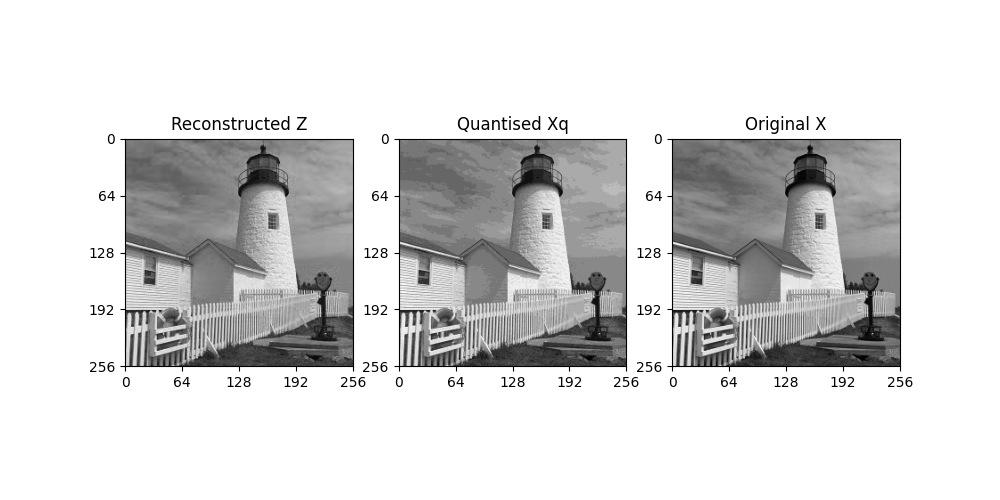

In [155]:
# Your code here
target_err = 4.8612
def rms_DCT_16 (step: float) -> float:
    Yq = quantise(Y, step)
    Z = colxfm(colxfm(Yq.T, C16.T).T, C16.T)
    #return rms error
    return np.std(X- Z)

def find_step_DCT_16(target_err, lo=1, hi=50, tol=0.001, max_iter= 5000):
    """Binary-search Δ so that rms_DCT(step) ≈ target_err."""    
    for _ in range(max_iter):          # failsafe upper bound
        mid = 0.5 * (lo + hi)
        e   = rms_DCT_16(mid)

        # stop if we're close enough
        if abs(e - target_err) <= tol:
            return mid, e

        # otherwise shrink the half-interval that gives too much error
        if e > target_err:
            hi = mid          # error too big, we need a smaller step
        if e < target_err:
            lo = mid          # error too small ⇒ we need a larger step

    # If we drop out because of max_iter, return the best we have
    return mid, e   #mid is the matched step size, e is the error

# optimise step size
opt_step, opt_error = find_step_DCT_16(4.8612)
print(f"\nmatched step ≈ {opt_step:.3f}  →  RMS = {opt_error:.3f}")

# compression ratio
N=16 
Yq = quantise(Y, step=22.342)
Yr = regroup(Yq, N) / N  
bits_sub = dctbpp(Yr, N=16)
bits_direct_quantisation = bpp(quantise(X, step=17) )* X.size
compression_ratio = bits_direct_quantisation / bits_sub
print(f"Bits (sum of per-tile entropies): {bits_sub:,.0f}")
print(f"Bits (direcct quantisation)   : {bits_direct_quantisation:,.0f}")
print(f"Comprssion ratio   : {compression_ratio}")

Z = colxfm(colxfm(Yq.T, C16.T).T, C16.T)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))
plot_image(Z, ax=ax1); ax1.set_title("Reconstructed Z")
plot_image(Xq, ax=ax2); ax2.set_title("Quantised Xq")
plot_image(X, ax=ax3); ax3.set_title("Original X")



This analysis is in fact slightly biased because with larger transform sizes the function `dctbpp(Yr, N)` will use a greater number of smaller sub-images on which to calculate probability distributions. It may be better to use the same N in this function even when the actual transform changes; however whether this is more predictive of actual coding performance depends on what scanning method is used in the coding scheme.

<div class="alert alert-block alert-danger">

What happens in the limit if you use `dctbpp(Yr, 256)` (i.e. the entropy is calculated independently for each pixel)? Why is this the case, and why isn't this a realistic result?</div>

In [156]:
# Your code here
N=256 
Yq = quantise(Y, step=17)
Yr = regroup(Yq, N) / N  
bits_sub = dctbpp(Yr, N)
print(bits_sub)

0.0


Entropy is zero for each pixel, there is no uncertainty. When N=256, the size of subimage is just one pixel. The entropy of each pixel is zero because we are creating the histogram with only one value with probability one. The entroy of the whole images would be zero .but entropy is the lower limit for encoding an image, so it cannot be zero .

<div class="alert alert-block alert-danger">

Can you draw any conclusions about the best choice of transform size for the
Lighthouse image?  Try to postulate what features in other images might make your
conclusions different, and suggest why.</div>

For lighthouse image, When N=8, it has the hightest compression ratio. JPEC is using N=8, it might a good transform size for most images. 

In [ ]:
# Your code here
